<a href="https://colab.research.google.com/github/JBVaNi/StuffSchool/blob/master/COVID19MX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [0]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd
import psycopg2 as ps

# Casos
url='/content/drive/My Drive/Colab Notebooks/Casos_Diarios_Estado_Nacional_Confirmados.csv'
confirmed=pd.read_csv(url, error_bad_lines=False)

url='/content/drive/My Drive/Colab Notebooks/Casos_Diarios_Estado_Nacional_Negativos.csv'
recover=pd.read_csv(url, error_bad_lines=False)

url='/content/drive/My Drive/Colab Notebooks/Casos_Diarios_Estado_Nacional_Defunciones.csv'
death=pd.read_csv(url, error_bad_lines=False)


In [0]:
!pip install qwikidata
import qwikidata
import qwikidata.sparql

def get_city_wikidata(city, country):
     query = """
     SELECT ?city ?cityLabel ?country ?countryLabel ?population
     WHERE
     {
       ?city rdfs:label '%s'@en.
       ?city wdt:P1082 ?population.
       ?city wdt:P17 ?country.
       ?city rdfs:label ?cityLabel.
       ?country rdfs:label ?countryLabel.
       FILTER(LANG(?cityLabel) = "en").
       FILTER(LANG(?countryLabel) = "en").
       FILTER(CONTAINS(?countryLabel, "%s")).
     }
     """ % (city, country)

     res = qwikidata.sparql.return_sparql_query_results(query)
     out = res['results']['bindings'][0]
     return ou

In [0]:
def create_ts(df):
  ts=df
  ts=ts.drop(['cve_ent', 'poblacion'], axis=1)
  ts.set_index('nombre')
  ts=ts.T
  ts.columns=ts.loc['nombre']
  ts=ts.drop('nombre')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)
  
 

In [0]:
# Recovered Guanajuato casses time series dataframe
ts=create_ts(confirmed)
ts_d=create_ts(death)
ts_rec=create_ts(recover)
print(ts)

Text(0.5, 1.0, 'Confirmados Diarios - Areas Principales')

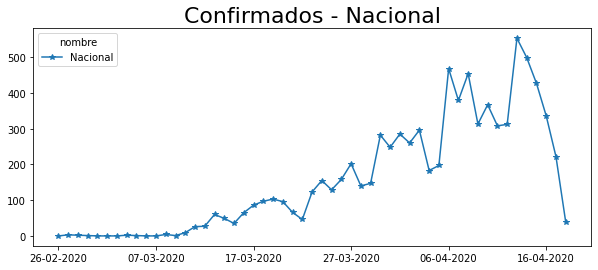

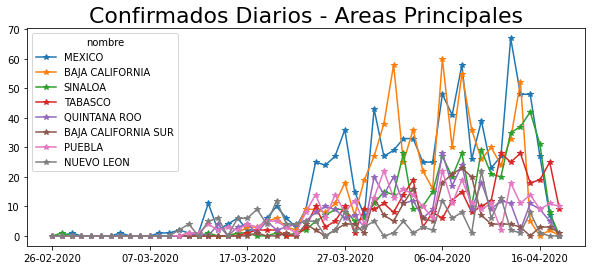

In [0]:
import matplotlib.pyplot as plt
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,:1].plot(marker='*',figsize=(10,4)).set_title('Confirmados - Nacional',fontdict={'fontsize': 22})
p.iloc[:,2:10].plot(marker='*',figsize=(10,4)).set_title('Confirmados Diarios - Areas Principales',fontdict={'fontsize': 22})

In [0]:
# Create data for R script
ts_r=ts.reset_index()
ts_r=ts_r.rename(columns = {'index':'date'})
ts_r['date']=pd.to_datetime(ts_r['date'] ,errors ='coerce')
ts_r.to_csv(r'/content/drive/My Drive/Colab Notebooks/Casos_Diarios_Estado_Nacional_Confirmados (1).csv')
print(ts_r)

In [0]:
import rpy2
%load_ext rpy2.ipython

In [0]:
%%R
install.packages('pracma')
install.packages('reshape')

In [0]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/content/drive/My Drive/Colab Notebooks/Casos_Diarios_Estado_Nacional_Confirmados (1).csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]


In [0]:
p=%R pred_all

In [0]:
############ Merge R output due to package problem
t=ts_d
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'nombre','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['nombre', 'date'])



In [0]:
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'nombre','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['nombre', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['nombre', 'date'])
t=t.reset_index(drop=True)

print(t)

In [0]:
t['last_day']=0
t=t.replace([np.inf, -np.inf], 0)
train=t.merge(confirmed[['nombre','poblacion']],how='left',on='nombre')
train=train.rename(columns = {'Poblacion ':'poblacion'})
train['poblacion']=train['poblacion'].replace(r" ", '')
train['poblacion']=train['poblacion'].replace(r",", '')
train['poblacion']=train['poblacion'].fillna(1)
train['poblacion']=train['poblacion'].astype('int64')
train['infected_rate'] =train['last_day']/train['poblacion']*10000
train=train.sort_values(['nombre', 'date'])

Text(0.5, 1.0, 'Kalman  - Seleccionar region para cambiar - GUANAJUATO')

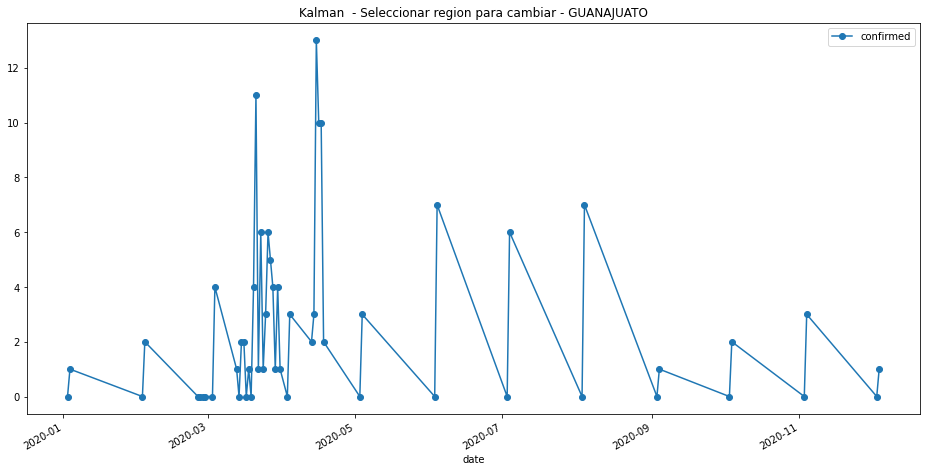

In [0]:
# Select region
region='GUANAJUATO'

p=t[t['nombre']==region][['date','nombre','confirmed',]]
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman  - Seleccionar region para cambiar - {}'.format(p.iloc[0,0]))
